Realistically, the robot is going to have some non-zero size, which will require that it plan to be at least somewhat far away from the walls. For this, we can include the inflation radius, which "inflates" (or "grows") the objects in the map so that it will plan farther around them. We also add a soft cost to the planner, which discourages being close to these newly inflated obstacles though does not outright prohibit it. We will also make the generated path sparser and "flipped" (so that the first point is the robot pose, rather than the other way around; this will be important later).

We will next inflate the grid, by a predefined amount `args.inflation_radius_m`, and replan with that grid to see how the plan changes so as to avoid being so close to obstacles. Notice how the grid and thus the path change.

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_object_search(known_graph, known_grid, robot, target_obj_info, simulator, args, cost=None, trajectory=None):
    plt.figure(figsize=(12, 12))

    # Known target container locations
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")

    # Plot whole scene graph
    ax = plt.subplot(221)
    plt.title('Whole Scene Graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)

    # Plot graph over occupancy grid
    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot.pose.x, robot.pose.y, '+', color='red', size=8, rotation=45)
    plt.title('Graph over Occupancy Grid')

    # Plot top-down view of the map
    plt.subplot(223)
    top_down_image = simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down View of the Map')
    plt.axis('off')

    # Plot robot trajectory
    ax = plt.subplot(224)
    if trajectory is not None:
        object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, robot.all_poses, trajectory, known_graph)
    else:
        plt.text(robot.pose.x, robot.pose.y, '+', color='red', size=8, rotation=45)
    if cost is not None:
        plt.title(f'Cost: {cost:.3f}')
    else:
        plt.title('Robot Trajectory')

    # Save figure
    save_path = Path(args.save_dir) / f'object_search_optimistic_{args.current_seed}.png'
    plt.savefig(save_path, dpi=1000)
    print(f'Plot saved to {save_path}')
    plt.show()


In [3]:
import matplotlib.pyplot as plt
import procthor
from procthor.simulators import SceneGraphSimulator
import object_search
from object_search.planners import PlanningLoop, OptimisticPlanner, LearnedPlannerFCNN
from pathlib import Path


def get_args():
    args = lambda key: None  # noqa
    args.save_dir = '/data/test_logs'
    args.current_seed = 0
    args.resolution = 0.05
    args.do_save_video = True
    # args.network_file = '/data/nn/fcnn.pt'
    return args


def test_object_search_optimistic_planner():
    '''Test object search in ProcTHOR environment with OptimisticPlanner'''
    
    args = get_args()
    thor_interface = procthor.ThorInterface(args)
    known_graph, known_grid, robot_pose, target_obj_info = thor_interface.gen_map_and_poses()
    simulator = SceneGraphSimulator(known_graph,
                                    args,
                                    target_obj_info,
                                    known_grid,
                                    thor_interface)
    #graph updates when the robot travels to the container
    robot = object_search.robot.Robot(robot_pose)
    #
    planner = OptimisticPlanner(target_obj_info, args)
    planning_loop = PlanningLoop(target_obj_info, simulator, robot, args=args, verbose=True)
    print("made it past planning loop")
    for _, step_data in enumerate(planning_loop):
        planner.update(
            step_data['observed_graph'],
            #observed grid stays the same
            step_data['observed_grid'],
            #the subgoals are just the containers, index of the node
            step_data['subgoals'],
            #
            step_data['robot_pose'])
        # plot_object_search(known_graph, known_grid, robot, target_obj_info, simulator, args, cost=cost, trajectory=trajectory)
        chosen_subgoal = planner.compute_selected_subgoal()
        planning_loop.set_chosen_subgoal(chosen_subgoal)

    cost, trajectory = object_search.utils.compute_cost_and_trajectory(known_grid, robot.all_poses)

    plt.figure(figsize=(8, 8))
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")

    ax = plt.subplot(221)
    plt.title('Whole scene graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)

    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot_pose.x, robot_pose.y, '+', color='red', size=6, rotation=45)
    plt.title('Graph over occupancy grid')

    plt.subplot(223)
    top_down_image = simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down view of the map')
    plt.axis('off')

    plt.subplot(224)
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, robot.all_poses, trajectory, known_graph)
    plt.title(f"Cost: {cost:0.3f}")



In [12]:
import matplotlib.pyplot as plt
import procthor
from procthor.simulators import SceneGraphSimulator
import object_search
from object_search.planners import PlanningLoop, OptimisticPlanner, LearnedPlannerFCNN
from pathlib import Path


def get_args():
    args = lambda key: None  # noqa
    args.save_dir = '/data/test_logs'
    args.current_seed = 0
    args.resolution = 0.05
    args.do_save_video = True
    args.network_file = '/data/nn/fcnn.pt'
    return args


def test_object_search_learned_planner():
    '''Test object search in ProcTHOR environment with OptimisticPlanner'''
    
    args = get_args()
    thor_interface = procthor.ThorInterface(args)
    known_graph, known_grid, robot_pose, target_obj_info = thor_interface.gen_map_and_poses()
    
    learned_simulator = SceneGraphSimulator(known_graph,
                                            args,
                                            target_obj_info,
                                            known_grid,
                                            thor_interface)

    learned_robot = object_search.robot.Robot(robot_pose)
    learned_planner = LearnedPlannerFCNN(target_obj_info, args)
    learned_planning_loop = PlanningLoop(target_obj_info, learned_simulator, learned_robot, args=args)

    for _, step_data in enumerate(learned_planning_loop):
        learned_planner.update(
            step_data['observed_graph'],
            step_data['observed_grid'],
            step_data['subgoals'],
            step_data['robot_pose'])

        chosen_subgoal = learned_planner.compute_selected_subgoal()
        learned_planning_loop.set_chosen_subgoal(chosen_subgoal)

    learned_cost, learned_trajectory = object_search.utils.compute_cost_and_trajectory(known_grid,
                                                                                       learned_robot.all_poses)
    cost, trajectory = object_search.utils.compute_cost_and_trajectory(known_grid, learned_robot.all_poses)

    plt.figure(figsize=(8, 8))
    known_locations = [known_graph.get_node_name_by_idx(idx) for idx in target_obj_info['container_idxs']]
    plt.suptitle(f"Seed: {args.current_seed} | Target object: {target_obj_info['name']}\n"
                 f"Known locations: {known_locations} ")

    ax = plt.subplot(221)
    plt.title('Whole scene graph')
    procthor.plotting.plot_graph(ax, known_graph.nodes, known_graph.edges)

    ax = plt.subplot(222)
    procthor.plotting.plot_graph_on_grid(ax, known_grid, known_graph)
    plt.text(robot_pose.x, robot_pose.y, '+', color='red', size=6, rotation=45)
    plt.title('Graph over occupancy grid')

    plt.subplot(223)
    top_down_image = learned_simulator.get_top_down_image()
    plt.imshow(top_down_image)
    plt.title('Top-down view of the map')
    plt.axis('off')

    plt.subplot(224)
    ax = plt.subplot(224)
    object_search.plotting.plot_grid_with_robot_trajectory(ax, known_grid, learned_robot.all_poses, trajectory, known_graph)
    plt.title(f"Cost: {cost:0.3f}")

-----------Using cached procthor data-----------
Target object: ladle
Known locations: ['countertop']
Counter: 0 | Count since last turnaround: 100
Ps=0.836 | at countertop
Ps=0.001 | at fridge
Ps=0.001 | at garbagebag
Searching in container: countertop
 
TOTAL TIME:  0.023039579391479492


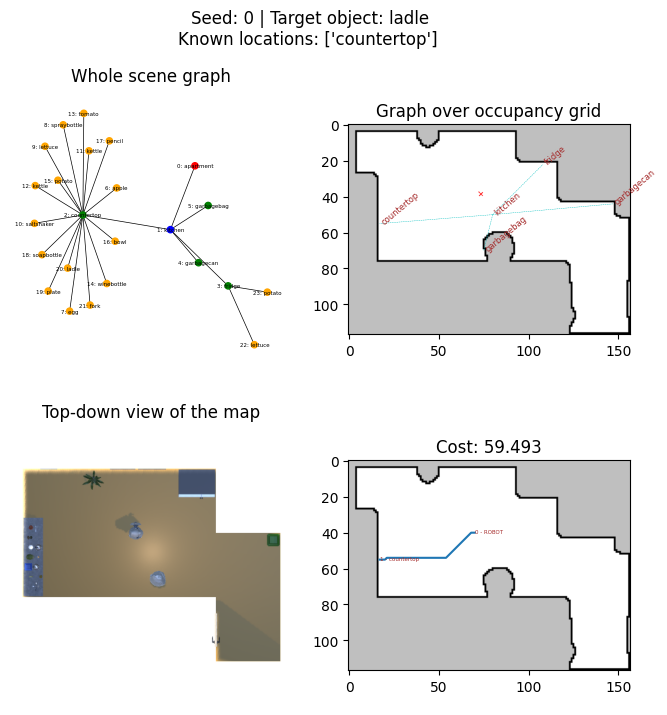

In [13]:
test_object_search_learned_planner()